# Proyecto de aprendizaje automático

Al fin han concedido un proyecto para tu *startup* de analítica con amplios conocimientos de aprendizaje automático y AI!!!! 

La **compañía de hoteles Disfrutín**, con hoteles ubicados por todo el mundo, está interesada en que construyas un modelo de clasificación de cancelaciones basándote en variables disponibles.

Para ello te ha proporcionado tres tablas:
- `bookings.csv`: contiene información de reservas
- `hotels.csv`:  contiene información sobre características de los hoteles
- `people.csv`: contiene información sobre los clientes del hotel

**La variable objetivo a estudiar es `is_canceled` y se ubica en la tabla `bookings`**

## Creación de conjuntos de datos

- Construye el conjunto de datos final basándote en las tres tablas proporcionadas, haciendo **merge** basado en las columnas naturales (`hotel` y `name`)
- Realiza una EDA con las agrupaciones que consideres y gráficos para intentar ver la influencia de algunas variables sobre la variable objetivo.
- Realiza ingeniería de atributos para ampliar los atributos iniciales con un mayor conjunto.
- Realiza una EDA para observar el impacto potencial de las variables creadas sobre la variable objetivo.

Tras este proceso, puede que tengas alguna idea de qué variables se pueden usar, cuáles son mejores predictores potenciales para estimar si se cancela o no la reserva, así como cuáles son categóricas, y cuáles son dummies.

- Genera la tabla final con todas las variables categóricas que correspondan transformadas en dummies.

## Modelado

- Divide el dataset generado en el paso anterior en entrenamiento y test siguiendo una proporción 0.8 - 0.2
- Haz uso del comando GridSearchCV junto con mallas de hiperparámetros (param_grid) y los modelos predictivos de árbol de decisión para clasificación y regresión logística estudiados, para generar un modelo predictivo óptimo que maximice la puntuación **f1-score**
- Para la mejor regresión logística obtenida, observa y pinta los coeficientes y realiza algún comentario u observación al respecto.
- Para el mejor árbol de decisión obtenido,  observa y pinta la importancia de atributos (feature importances) y realiza algún comentario u observación al respecto.
- Para el mejor modelo obtenido por la búsuqeda Gridsearchcv, realiza la predicción en TEST, y aporta las métricas accuracy, precission, recall así como la matriz de confusión, para el umbral estándar (0.5)

- Para este mejor modelo, busca el umbral que satisfaga las siguientes condiciones, evaluando en TEST:
    - Umbral mínimo que garantiza una precission del 80 %
    - Umbral máximo que garantiza un recall del 60 %
    - Umbral que maximiza la f1 score
- Para el umbral que maximiza la f1, reporta los rendimientos f1 agrupando por hotel, ¿ para qué hoteles obtienes un peor rendimiento? 

# Análisis final

Tenemos una entrevista con el departamento de marketing de la empresa para explicar los modelos obtenidos y el análisis en profundidad acometido, que asentará nuestro amplio conocimiento y habilidades analíticas de cara a la cadena hotelera y nos garantizará futuros contratos, nos preguntan elementos esenciales como:

- ¿ qué hoteles o países de hoteles tienen una mayor tasa de cancelación? 
- ¿ qué países de cliente tienen una mayor tasa de cancelación?
- ¿ existen rangos de edad para los cuales la tasa de cancelación es mayor o menor que la media?
- ¿ afecta la anticipación en la reserva de algún modo a la tasa de cancelación?
- ¿ hay algún tipo de habitación que sufra mayor propensión a las cancelaciones?
- ¿ afecta la distribución de los huéspedes de algún modo a la tasa de cancelación?
- ¿ afectan los servicios disponibles del hotel a la tasa de cancelación?
- ¿ qué activaciones de marketing/comerciales podemos realizar sobre la predicción del modelo de cancelaciones para reducir las mismas y mejorar la tasa de reservas que se completan?


Dependiendo de la brillantez en la exposición del modelo, su rendimiento y los resultados analíticos, Disfrutín iniciará con nosotros una feliz relación de colaboración en tareas de ciencia de datos, o seremos una consultora más quedará atrás tras meter un pufo en el proyecto como impostores.

# 1 Creación de conjuntos de datos

In [130]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [131]:
df_booking = pd.read_csv("bookings.csv")
df_booking.sample()

,booking_id,name,hotel,booking_timestamp,n_rooms,room_type,children,arrival_timestamp,leave_timestamp,guests,total_cost,is_canceled
4080,8c9dd2ae-059b-4b8c-965d-9fef852c3f97,James Thomas,GNT,2022-05-29 02:25:41,1,triple,0,2022-07-10,2022-07-24,1,2388.94,False


In [132]:
df_hotels = pd.read_csv("hotels.csv")
df_hotels.sample()

,hotel,hotel_country,has_pool,has_spa,has_theatre,stars
18,CJY,Tokelau,False,True,False,1


In [133]:
df_people = pd.read_csv("people.csv")
df_people.sample()

,name,country,date_of_birth
1205,Thomas Adkins,India,1971-03-28


In [134]:
df = pd.merge(df_booking, df_hotels, on="hotel")
df = pd.merge(df, df_people, on="name")
df.sample()

,booking_id,name,hotel,booking_timestamp,n_rooms,room_type,children,arrival_timestamp,leave_timestamp,guests,total_cost,is_canceled,hotel_country,has_pool,has_spa,has_theatre,stars,country,date_of_birth
1179,d87d361f-ba61-4c3b-ade1-152f2246b3b9,Timothy Williams,ZDC,2022-02-24 04:15:23,1,triple,0,2022-04-11,2022-04-16,3,818.28,True,Malaysia,False,True,True,1,Syrian Arab Republic,1964-01-11


In [135]:
df.booking_timestamp = pd.to_datetime(df.booking_timestamp)
df.arrival_timestamp = pd.to_datetime(df.arrival_timestamp)
df.leave_timestamp = pd.to_datetime(df.leave_timestamp)
df.date_of_birth = pd.to_datetime(df.date_of_birth)

In [136]:
df.dtypes

booking_id                   object
name                         object
hotel                        object
booking_timestamp    datetime64[ns]
n_rooms                       int64
room_type                    object
children                      int64
arrival_timestamp    datetime64[ns]
leave_timestamp      datetime64[ns]
guests                        int64
total_cost                  float64
is_canceled                    bool
hotel_country                object
has_pool                       bool
has_spa                        bool
has_theatre                    bool
stars                         int64
country                      object
date_of_birth        datetime64[ns]
dtype: object

## 1.1 FIRST EDA

In [137]:
NUMERICAL_FEATURES = ["n_rooms", "children", "guests", "total_cost", "stars"]
CATEGORICAL_FEATURES = [ "room_type", "hotel_country", "has_pool", "has_spa",
                        "has_theatre", "country"]

In [138]:
def explore_predictor_capacity(df, predictor_name, is_cat=False):
    print("PREDICTOR ANALYSIS:", predictor_name)
    if is_cat:
        discrete_predictor = df[predictor_name]
    else:
        discrete_predictor = pd.qcut(df[predictor_name], 10, duplicates='drop')
    print(df.groupby(discrete_predictor).is_canceled.agg(['count', 'mean']))
    (df.groupby(discrete_predictor).is_canceled.mean()).plot.bar(figsize=(10, 5), ylim=(0, 1));
    plt.axhline(df.is_canceled.mean(), c='r');
    plt.show()

# explore_predictor_capacity(df, "guests")

PREDICTOR ANALYSIS: n_rooms
              count      mean
n_rooms                      
(0.999, 2.0]   4073  0.294623
(2.0, 3.0]      472  0.302966
(3.0, 4.0]      455  0.375824


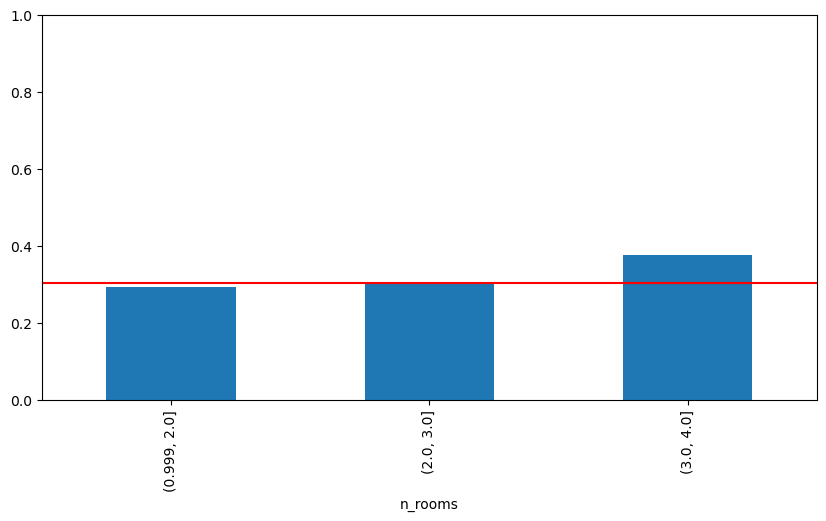

PREDICTOR ANALYSIS: children
               count      mean
children                      
(-0.001, 1.0]   4037  0.303939
(1.0, 2.0]       479  0.340292
(2.0, 3.0]       484  0.256198


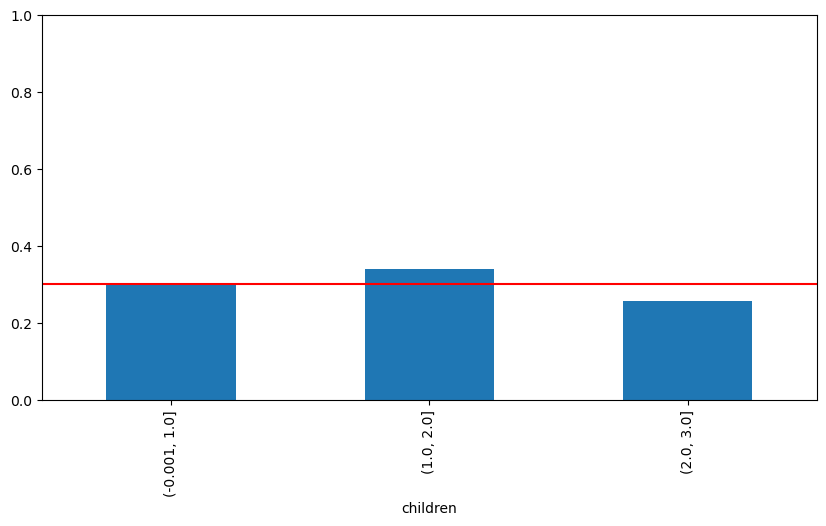

PREDICTOR ANALYSIS: guests
              count      mean
guests                       
(0.999, 2.0]   2852  0.294180
(2.0, 3.0]      523  0.242830
(3.0, 4.0]      813  0.280443
(4.0, 6.0]      398  0.374372
(6.0, 24.0]     414  0.413043


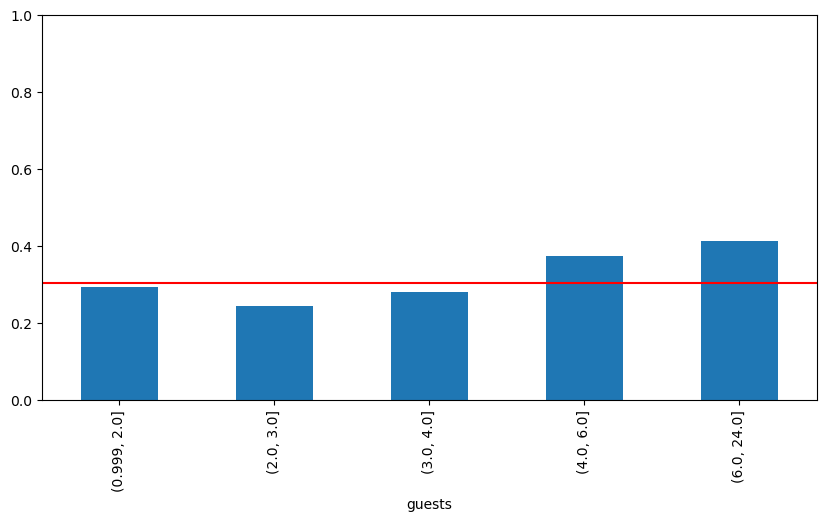

PREDICTOR ANALYSIS: total_cost
                      count   mean
total_cost                        
(56.039, 335.426]       500  0.292
(335.426, 557.672]      500  0.292
(557.672, 801.237]      500  0.310
(801.237, 1071.258]     500  0.314
(1071.258, 1381.63]     500  0.302
(1381.63, 1743.816]     500  0.252
(1743.816, 2329.431]    500  0.280
(2329.431, 3177.532]    500  0.290
(3177.532, 4768.213]    500  0.308
(4768.213, 23428.24]    500  0.388


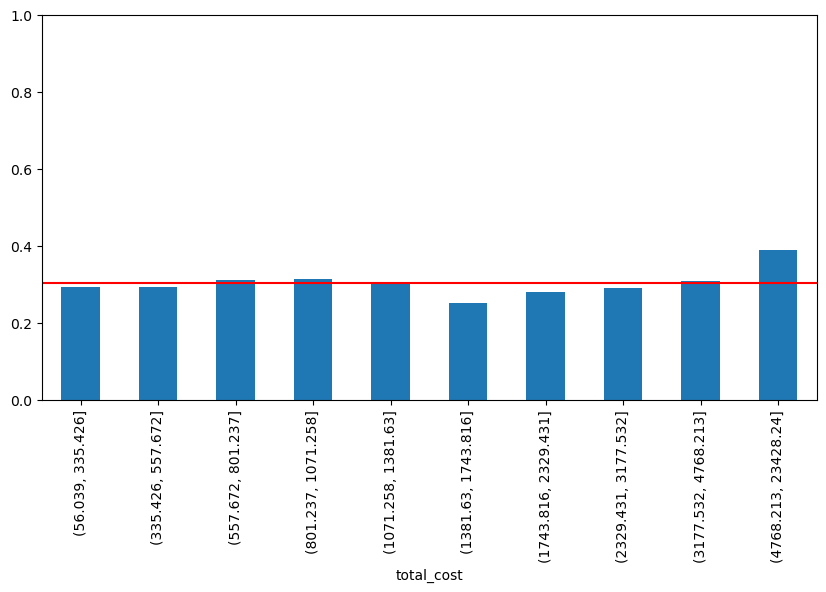

PREDICTOR ANALYSIS: stars
              count      mean
stars                        
(0.999, 2.0]   2219  0.310500
(2.0, 3.0]      468  0.282051
(3.0, 4.0]     1331  0.289256
(4.0, 5.0]      982  0.313646


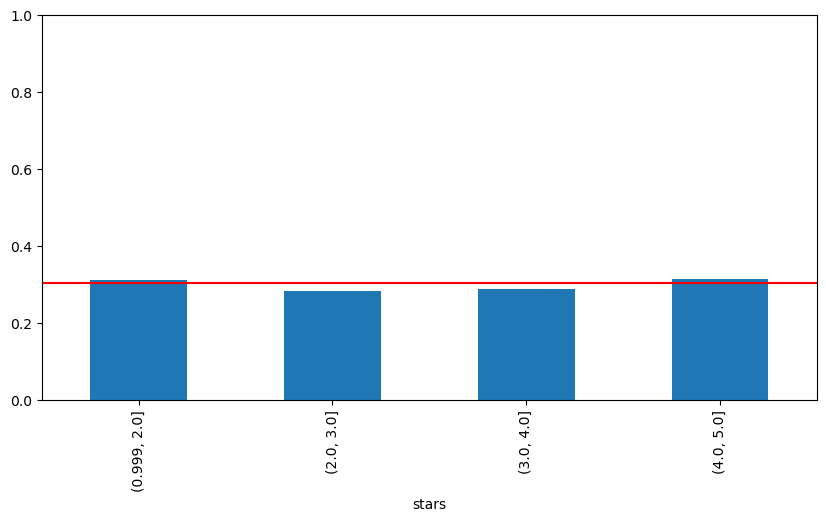

In [139]:
for numeric_predictor in NUMERICAL_FEATURES:
    explore_predictor_capacity(df, numeric_predictor)

PREDICTOR ANALYSIS: room_type
           count      mean
room_type                 
double      2047  0.262824
luxury       480  0.333333
single      1014  0.249507
suite        503  0.479125
triple       956  0.336820


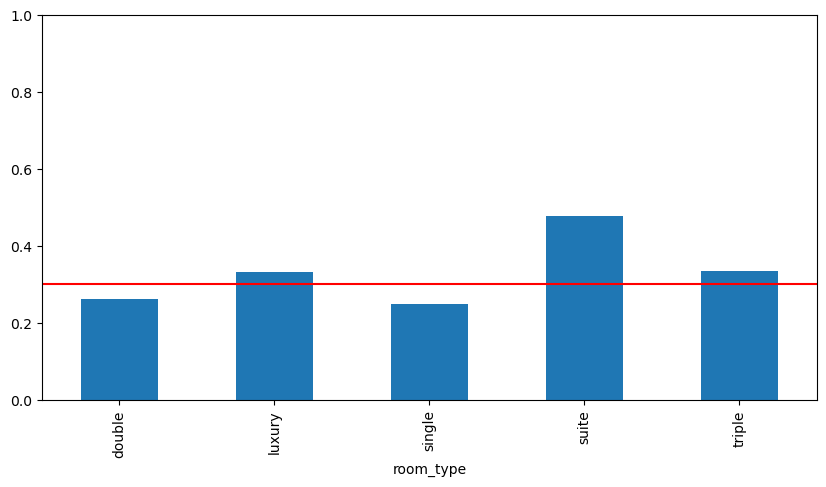

PREDICTOR ANALYSIS: hotel_country
                           count      mean
hotel_country                             
Albania                      152  0.289474
American Samoa               171  0.362573
Argentina                    189  0.269841
Aruba                        179  0.268156
Austria                      165  0.212121
Bangladesh                   156  0.173077
Belarus                      157  0.382166
Bouvet Island (Bouvetoya)    169  0.224852
Brazil                       160  0.481250
Cape Verde                   158  0.284810
Chad                         180  0.288889
Cote d'Ivoire                164  0.231707
Fiji                         187  0.368984
Greenland                    166  0.445783
Guam                         161  0.180124
Iceland                      159  0.176101
India                        168  0.297619
Japan                        163  0.220859
Kuwait                       170  0.147059
Liechtenstein                152  0.355263
Malawi              

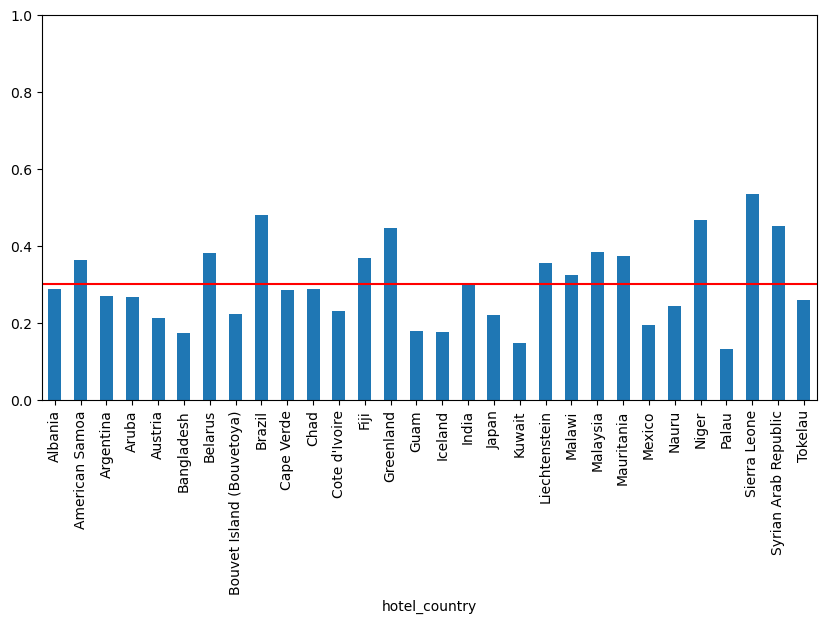

PREDICTOR ANALYSIS: has_pool
          count      mean
has_pool                 
False      2542  0.311172
True       2458  0.294142


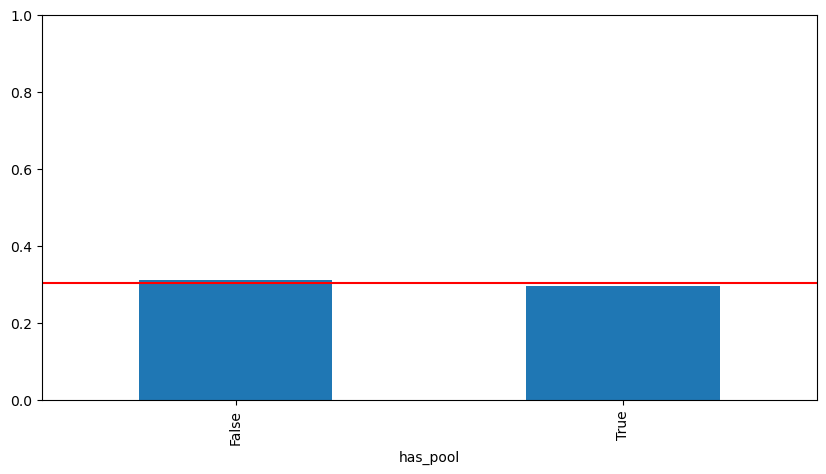

PREDICTOR ANALYSIS: has_spa
         count      mean
has_spa                 
False     1865  0.336193
True      3135  0.282935


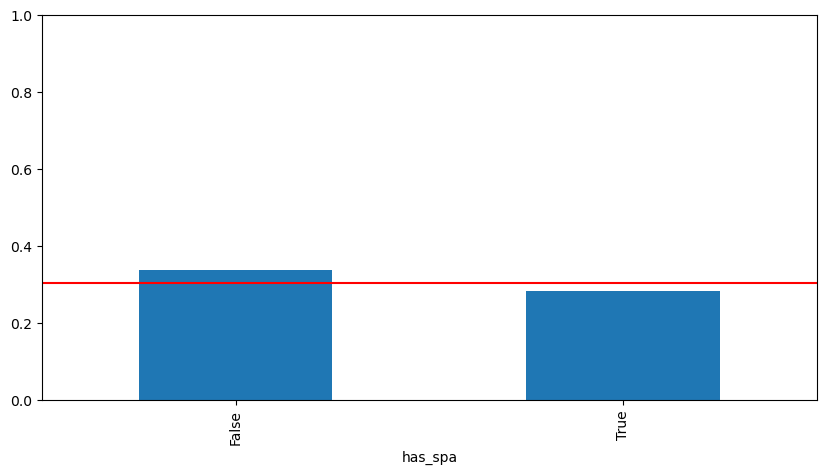

PREDICTOR ANALYSIS: has_theatre
             count      mean
has_theatre                 
False         1891  0.323638
True          3109  0.290125


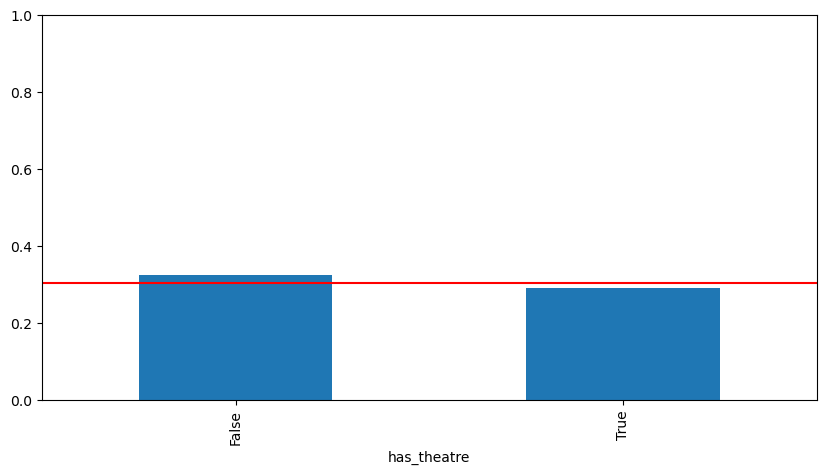

PREDICTOR ANALYSIS: country
                           count      mean
country                                   
Albania                      141  0.205674
American Samoa               164  0.250000
Argentina                    156  0.237179
Aruba                        166  0.433735
Austria                      170  0.500000
Bangladesh                   156  0.506410
Belarus                      170  0.476471
Bouvet Island (Bouvetoya)    187  0.326203
Brazil                       188  0.478723
Cape Verde                   156  0.250000
Chad                         196  0.193878
Cote d'Ivoire                150  0.233333
Fiji                         166  0.234940
Greenland                    161  0.378882
Guam                         160  0.162500
Iceland                      125  0.200000
India                        172  0.261628
Japan                        160  0.243750
Kuwait                       148  0.270270
Liechtenstein                155  0.167742
Malawi                    

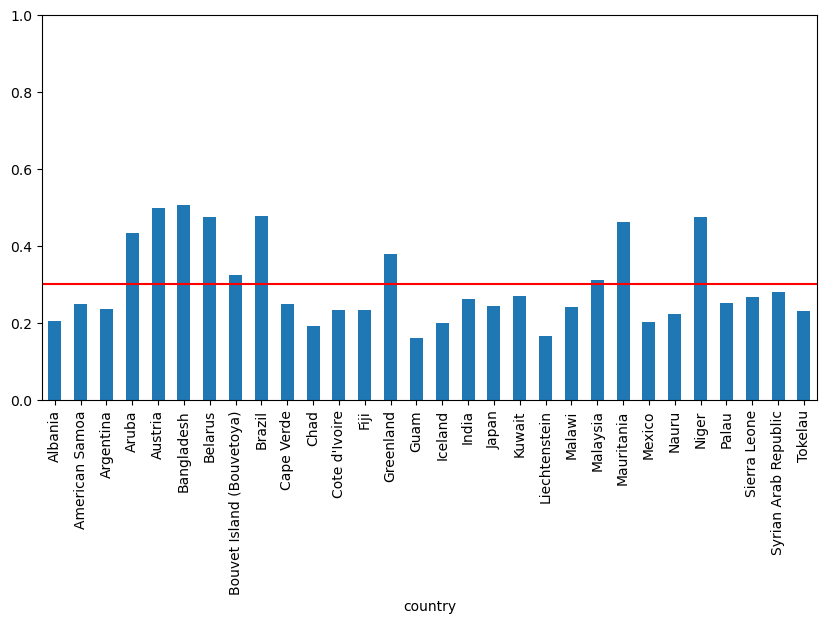

In [140]:
for numeric_predictor in CATEGORICAL_FEATURES:
    explore_predictor_capacity(df, numeric_predictor, is_cat=True)

## 1.2 Ingeniería de atributos

In [141]:
df["booking_month"] = df.booking_timestamp.dt.month
df["age"] = ((df.booking_timestamp - df.date_of_birth).dt.total_seconds() / 3600.0 / 24.0 / 365.0).round(1)
df["has_spa_and_threatre"] = df.has_spa & df.has_theatre
df["has_spa_and_pool"] = df.has_spa & df.has_pool
df["has_pool_and_threatre"] = df.has_pool & df.has_theatre
df['n_nights'] = (df.leave_timestamp - df.arrival_timestamp).dt.days
df['anticipation'] = (df.arrival_timestamp - df.booking_timestamp).dt.days
df['normalized_cost'] = df.total_cost / df.guests / df.n_nights / df.n_rooms
df['same_country'] = df.hotel_country.eq(df.country)

In [142]:
df.sample(3)

,booking_id,name,hotel,booking_timestamp,n_rooms,room_type,children,arrival_timestamp,leave_timestamp,guests,...,date_of_birth,booking_month,age,has_spa_and_threatre,has_spa_and_pool,has_pool_and_threatre,n_nights,anticipation,normalized_cost,same_country
801,51200ac7-a094-4b2d-add7-08580d099111,Randy Joseph,GZD,2022-11-17 19:33:16,4,suite,0,2023-01-22,2023-02-01,4,...,1982-07-27,11,40.3,True,True,True,10,65,105.077187,False
1040,c24c1aa6-d163-4a88-b0c5-e50ff7e48fb8,Joann Sherman,QPT,2022-12-25 17:38:57,1,suite,0,2023-01-17,2023-01-29,1,...,1983-11-05,12,39.2,False,True,False,12,22,412.591667,False
1878,757968d7-8533-44f5-9422-578f619aea63,Linda Williams,PEV,2022-09-28 20:34:14,2,double,0,2022-11-21,2022-11-24,4,...,1998-08-09,9,24.2,True,False,False,3,53,29.057917,False


## 1.3 EDA AFTER FEATURE ENGINEERING

In [143]:
FE_NUMERICAL_FEATURES = ["age", "n_nights", "anticipation", "normalized_cost"]
FE_CATEGORICAL_FEATURES = [
    "booking_month", "has_spa_and_threatre", "has_spa_and_pool",
    "has_pool_and_threatre", "same_country"
]

PREDICTOR ANALYSIS: age
                count      mean
age                            
(18.299, 24.9]    512  0.535156
(24.9, 30.4]      495  0.496970
(30.4, 36.2]      496  0.310484
(36.2, 42.0]      498  0.325301
(42.0, 47.7]      501  0.295409
(47.7, 52.9]      504  0.291667
(52.9, 58.2]      501  0.327345
(58.2, 63.6]      496  0.133065
(63.6, 68.9]      502  0.151394
(68.9, 75.2]      495  0.155556


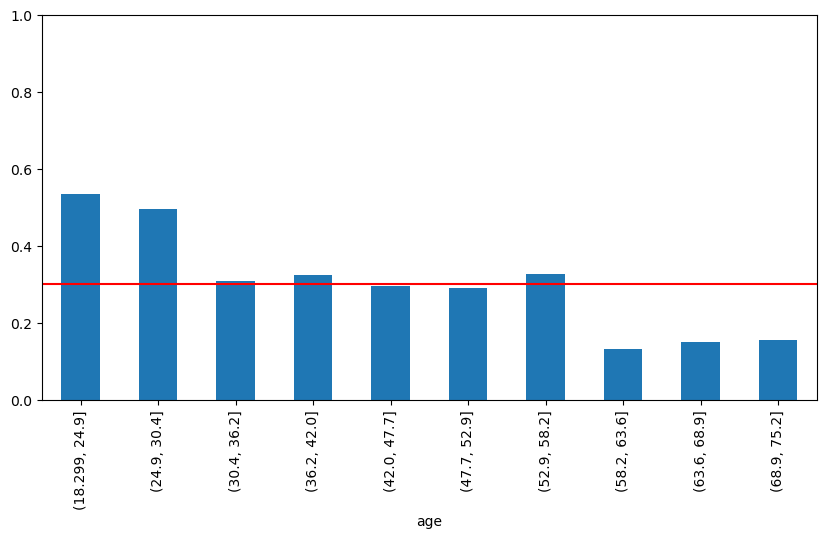

PREDICTOR ANALYSIS: n_nights
              count      mean
n_nights                     
(0.999, 2.0]    705  0.314894
(2.0, 3.0]      366  0.379781
(3.0, 5.0]      735  0.338776
(5.0, 6.0]      350  0.371429
(6.0, 7.0]      351  0.336182
(7.0, 9.0]      721  0.382802
(9.0, 10.0]     380  0.371053
(10.0, 12.0]    665  0.154887
(12.0, 13.0]    367  0.177112
(13.0, 14.0]    360  0.197222


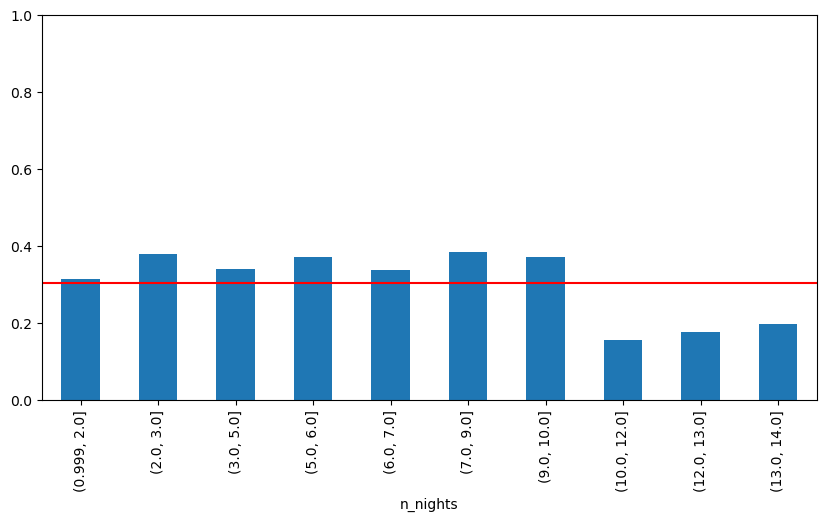

PREDICTOR ANALYSIS: anticipation
               count      mean
anticipation                  
(-0.001, 9.0]    539  0.289425
(9.0, 18.0]      498  0.261044
(18.0, 27.0]     502  0.249004
(27.0, 35.0]     509  0.312377
(35.0, 43.0]     472  0.305085
(43.0, 52.0]     512  0.359375
(52.0, 61.0]     491  0.297352
(61.0, 70.0]     491  0.344196
(70.0, 79.0]     512  0.310547
(79.0, 88.0]     474  0.299578


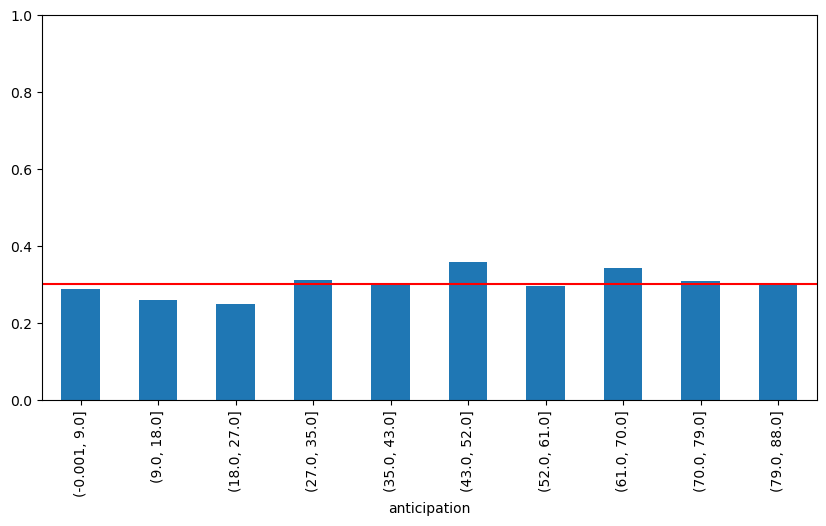

PREDICTOR ANALYSIS: normalized_cost
                              count   mean
normalized_cost                           
(12.975000000000001, 25.405]    500  0.296
(25.405, 30.504]                500  0.242
(30.504, 39.902]                500  0.330
(39.902, 54.393]                500  0.314
(54.393, 59.071]                500  0.210
(59.071, 65.424]                500  0.246
(65.424, 78.104]                500  0.288
(78.104, 104.497]               500  0.326
(104.497, 131.8]                500  0.316
(131.8, 437.077]                500  0.460


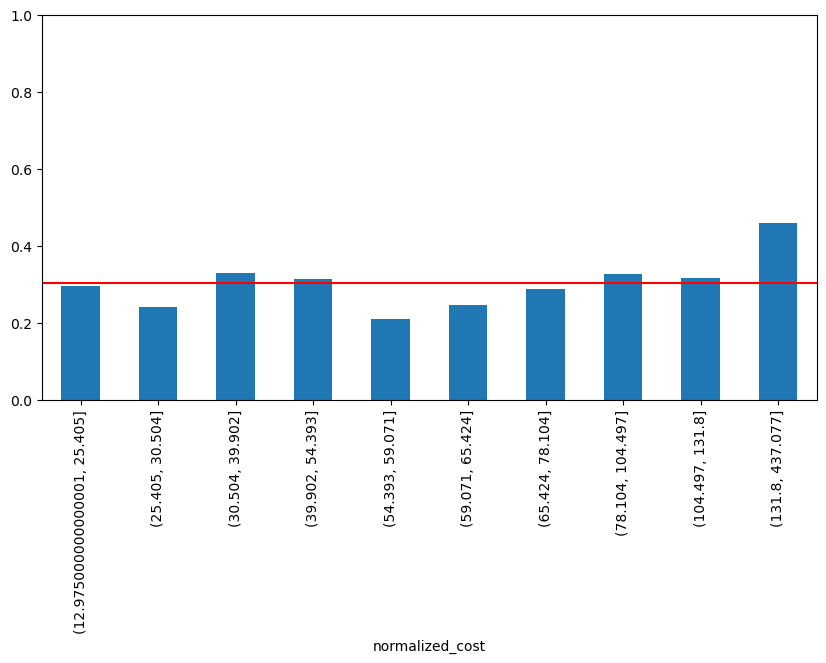

In [144]:
for numeric_predictor in FE_NUMERICAL_FEATURES:
    explore_predictor_capacity(df, numeric_predictor, is_cat=False)

PREDICTOR ANALYSIS: booking_month
               count      mean
booking_month                 
1                432  0.287037
2                373  0.305630
3                409  0.293399
4                410  0.304878
5                416  0.322115
6                452  0.296460
7                432  0.347222
8                412  0.300971
9                388  0.293814
10               475  0.305263
11               398  0.311558
12               403  0.263027


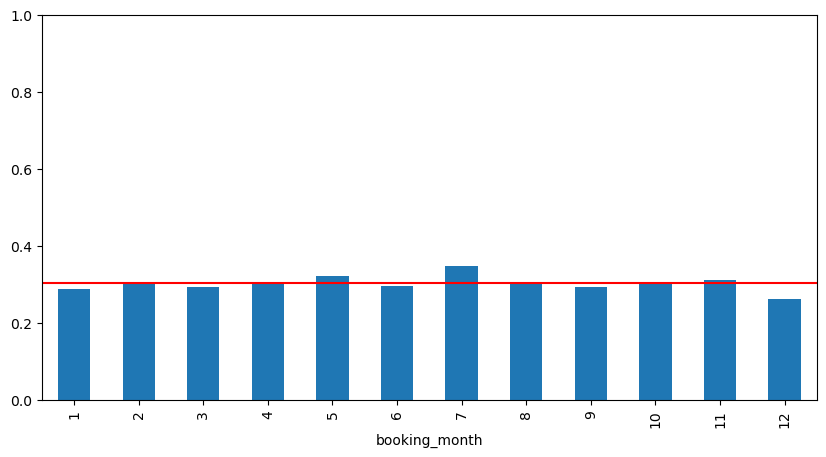

PREDICTOR ANALYSIS: has_spa_and_threatre
                      count      mean
has_spa_and_threatre                 
False                  3061  0.325711
True                   1939  0.266632


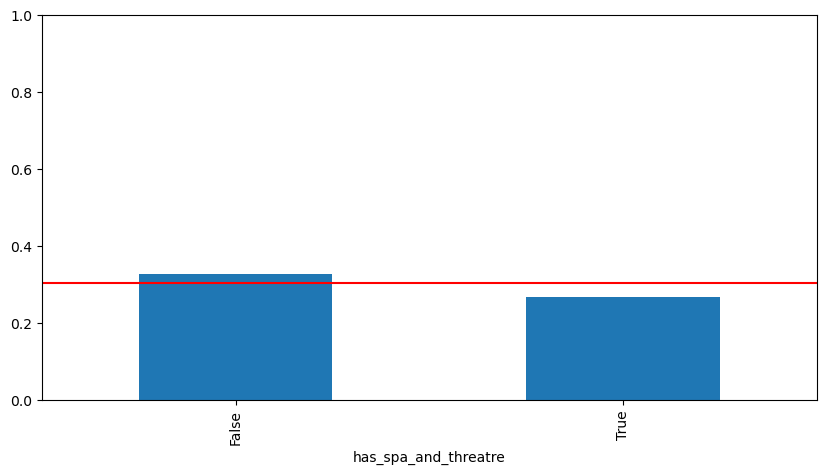

PREDICTOR ANALYSIS: has_spa_and_pool
                  count      mean
has_spa_and_pool                 
False              3692  0.313651
True               1308  0.272171


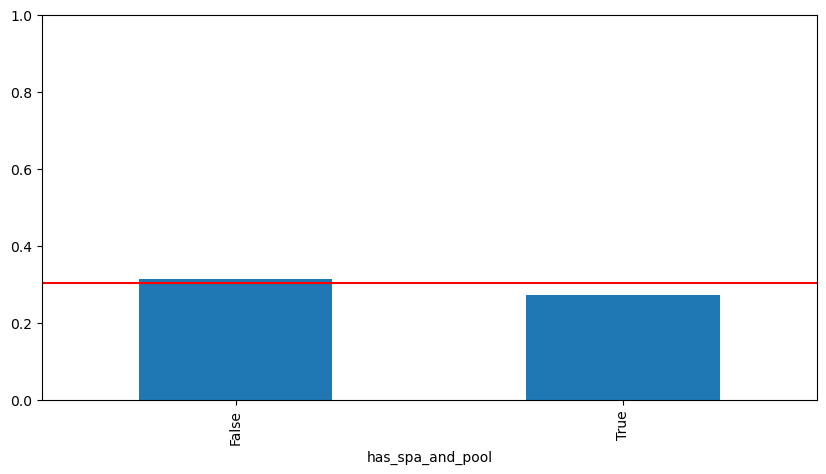

PREDICTOR ANALYSIS: has_pool_and_threatre
                       count      mean
has_pool_and_threatre                 
False                   3573  0.311503
True                    1427  0.281009


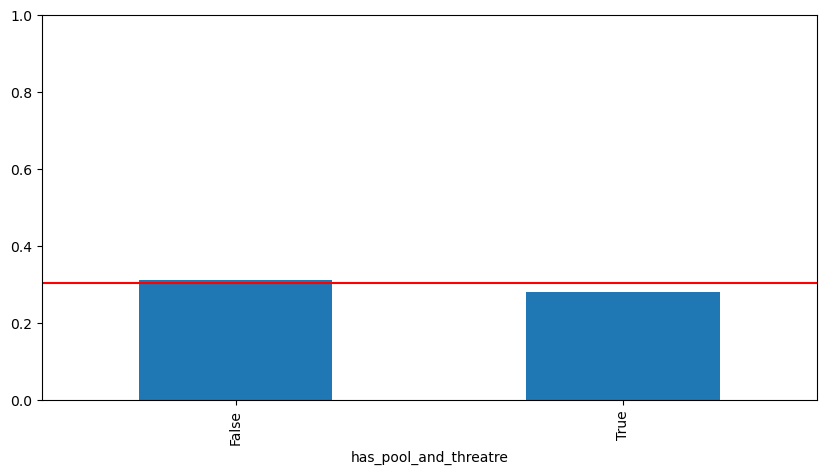

PREDICTOR ANALYSIS: same_country
              count      mean
same_country                 
False          4830  0.303106
True            170  0.294118


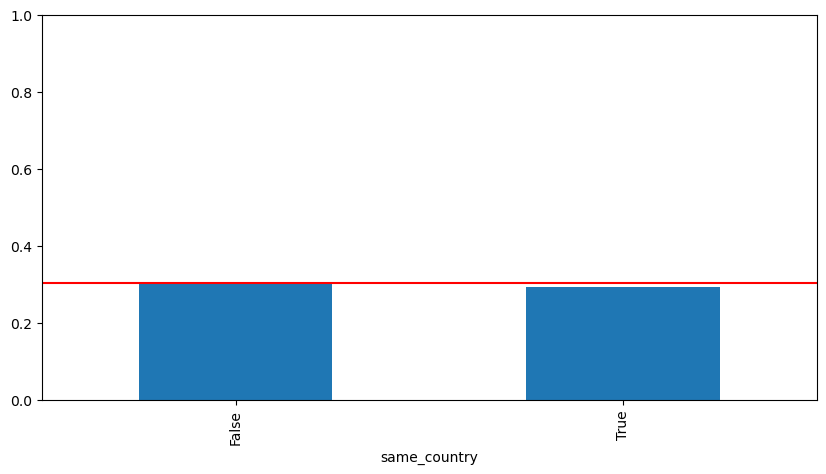

In [145]:
for numeric_predictor in FE_CATEGORICAL_FEATURES:
    explore_predictor_capacity(df, numeric_predictor, is_cat=True)

## 1.4 Create dummies

In [146]:
NUMERICAL_FEATURES = list(set(NUMERICAL_FEATURES).union(FE_NUMERICAL_FEATURES))
CATEGORICAL_FEATURES = list(set(CATEGORICAL_FEATURES).union(FE_CATEGORICAL_FEATURES))

In [147]:
FEATURES = list(set(NUMERICAL_FEATURES).union(CATEGORICAL_FEATURES))

In [148]:
df[CATEGORICAL_FEATURES].sample(3)

,has_pool,has_spa_and_threatre,room_type,has_theatre,same_country,has_spa_and_pool,has_pool_and_threatre,hotel_country,has_spa,booking_month,country
4024,False,False,double,True,False,False,False,Nauru,False,1,Sierra Leone
1130,False,True,double,True,False,False,False,Belarus,True,4,Kuwait
1250,True,False,triple,False,False,False,False,Cape Verde,False,4,Tokelau


In [149]:
df[NUMERICAL_FEATURES].sample(3)

,anticipation,guests,age,stars,n_nights,total_cost,normalized_cost,n_rooms,children
2122,74,8,28.9,1,3,1338.66,13.944375,4,1
2949,48,3,43.1,4,1,234.97,26.107778,3,0
1009,80,2,25.3,1,10,1617.61,80.880500,1,0


In [150]:
df[FEATURES].sample(3)

,has_pool,room_type,age,stars,same_country,total_cost,has_spa_and_pool,hotel_country,booking_month,anticipation,guests,has_spa_and_threatre,has_theatre,n_nights,normalized_cost,has_pool_and_threatre,n_rooms,has_spa,children,country
1679,True,single,57.9,4,False,1676.46,True,Mexico,5,40,2,True,True,11,38.101364,True,2,True,1,Guam
3128,True,triple,55.2,5,False,3212.62,True,Liechtenstein,7,53,3,True,True,6,59.492963,True,3,True,0,Malawi
4951,True,double,30.5,5,False,136.57,True,Liechtenstein,10,5,2,True,True,1,68.285000,True,1,True,0,Fiji


In [151]:
# DUMMY_FEATURES = ['hotel_country', 'country', 'booking_month', 'room_type']
# model_df = pd.get_dummies(df, columns=DUMMY_FEATURES)

In [152]:
DUMMY_FEATURES = ['hotel_country', 'country', 'booking_month', 'room_type']
X = pd.get_dummies(df[FEATURES], columns=DUMMY_FEATURES)

In [153]:
y = df.is_canceled

In [154]:
X.shape, y.shape

((5000, 93), (5000,))

In [155]:
X.sample(5)

,has_pool,age,stars,same_country,total_cost,has_spa_and_pool,anticipation,guests,has_spa_and_threatre,has_theatre,...,booking_month_8,booking_month_9,booking_month_10,booking_month_11,booking_month_12,room_type_double,room_type_luxury,room_type_single,room_type_suite,room_type_triple
1444,True,53.8,4,False,1965.11,True,68,4,True,True,...,False,False,False,False,False,False,False,True,False,False
1456,True,22.0,1,False,4147.58,True,18,4,False,False,...,True,False,False,False,False,False,False,False,False,True
3824,True,44.3,2,False,920.39,True,63,2,False,False,...,False,False,False,False,False,False,False,True,False,False
339,True,40.7,1,False,1372.97,False,74,2,False,True,...,False,True,False,False,False,True,False,False,False,False
654,False,48.7,1,False,395.27,False,53,1,True,True,...,False,False,False,False,False,False,False,True,False,False


# 2 Modelado

In [156]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [157]:
print("Forma de X_train:", X_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (4000, 93)
Forma de X_test: (1000, 93)
Forma de y_train: (4000,)
Forma de y_test: (1000,)


## 2.1 Arbol de decision

### 2.1.1 Entrenamiento

In [158]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import precision_score, recall_score, f1_score
from numpy import arange

In [159]:
# Definir la malla de hiperparámetros a explorar
# param_grid_dt = {
#     "max_depth": [None, 10, 20, 30],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4],
#     "max_features": ["auto", "sqrt", "log2"],
# }

param_grid_dt = {
    "max_depth": arange(3, 15), 
    "criterion": ["gini", "entropy"],
    "max_leaf_nodes": [2**4, 2**6, 2**8, 2**10],
    "min_samples_leaf": [10, 20, 30, 90],
}
# Crear el objeto GridSearchCV
grid_search_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=0),
    param_grid=param_grid_dt,
    scoring="f1",
    cv=5,
    n_jobs=6,
    refit=True,
)

# Ajustar el modelo a los datos de entrenamiento
grid_search_dt.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params_dt = grid_search_dt.best_params_

# Obtener el modelo con los mejores hiperparámetros
best_model_dt = grid_search_dt.best_estimator_

best_score_dt = grid_search_dt.best_score_

# Predecir en el conjunto de prueba
y_pred_dt = best_model_dt.predict(X_test)

print("Mejores hiperparámetros para Árbol de Decisión:", best_params_dt)
print("best mean cross-validation score:{:.3}".format( best_score_dt))
print("Mejor modelo: ", best_model_dt)

Mejores hiperparámetros para Árbol de Decisión: {'criterion': 'gini', 'max_depth': 9, 'max_leaf_nodes': 16, 'min_samples_leaf': 10}
best mean cross-validation score:0.484
Mejor modelo:  DecisionTreeClassifier(max_depth=9, max_leaf_nodes=16, min_samples_leaf=10,
                       random_state=0)


### 2.1.2 Test

In [160]:
print(classification_report(y_test, y_pred_dt))
print("Precission:", precision_score(y_true=y_test, y_pred=y_pred_dt))
print("Recall:", recall_score(y_true=y_test, y_pred=y_pred_dt))
print("F1-score:", f1_score(y_true=y_test, y_pred=y_pred_dt))

              precision    recall  f1-score   support

       False       0.77      0.88      0.82       700
        True       0.58      0.38      0.46       300

    accuracy                           0.73      1000
   macro avg       0.68      0.63      0.64      1000
weighted avg       0.71      0.73      0.71      1000

Precission: 0.5846153846153846
Recall: 0.38
F1-score: 0.46060606060606063


## 2.2 Regresion logística

### 2.2.1 Entrenamiento

In [161]:
# Definir la malla de hiperparámetros a explorar
# param_grid_lr = {
#     "C": [0.001, 0.05, 0.01, 0.05, 1, 2, 5, 10],
#     "penalty": ["l1", "l2"],
#     "solver": ["liblinear", "lbfgs"],
# }
param_grid_lr = {
    "C": [0.001, 0.05, 0.01, 0.05, 1, 2, 5, 10],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear", "lbfgs"],
}
# Crear el objeto GridSearchCV
grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(random_state=0),
    param_grid=param_grid_lr,
    scoring="f1",
    # cv=5,
    n_jobs=6,
    refit=True,
)

# Ajustar el modelo a los datos de entrenamiento
grid_search_lr.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params_lr = grid_search_lr.best_params_

# Obtener el modelo con los mejores hiperparámetros
best_model_lr = grid_search_lr.best_estimator_

# Predecir en el conjunto de prueba
y_pred_lr = best_model_lr.predict(X_test)

print("Mejores hiperparámetros para Regresión Logística:", best_params_lr)
print("Mejor modelo: ", best_model_lr)

Mejores hiperparámetros para Regresión Logística: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Mejor modelo:  LogisticRegression(C=10, penalty='l1', random_state=0, solver='liblinear')


e:\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "e:\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = _check_solver(self.solver, self.penalty, self.du

### 2.2.2 Test

In [162]:
print(classification_report(y_test, y_pred_lr))
print("Precission:", precision_score(y_true=y_test, y_pred=y_pred_lr))
print("Recall:", recall_score(y_true=y_test, y_pred=y_pred_lr))
print("F1-score:", f1_score(y_true=y_test, y_pred=y_pred_lr))

              precision    recall  f1-score   support

       False       0.78      0.91      0.84       700
        True       0.66      0.40      0.50       300

    accuracy                           0.76      1000
   macro avg       0.72      0.66      0.67      1000
weighted avg       0.75      0.76      0.74      1000

Precission: 0.664804469273743
Recall: 0.39666666666666667
F1-score: 0.49686847599164935
